In [7]:
import re
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
sns.set_palette('Blues_d')
plt.style.use("steam_style.mplstyle")

## Importing and process data
### Convert data types
I don't process data from Languages, Genres and Steam categories columns because this data will not be needed in the future.

In [8]:
df = pd.read_csv('../collect_data/steam_data.csv')

display(df.dtypes)
display(df.head(2))

Title                 object
Release date          object
Developer             object
Publisher             object
Reviews count         object
Reviews summary       object
Positive percent      object
Tags                  object
Price                 object
Languages             object
Achievements count     int64
Genres                object
Steam categories      object
Sys req               object
dtype: object

,Title,Release date,Developer,Publisher,Reviews count,Reviews summary,Positive percent,Tags,Price,Languages,Achievements count,Genres,Steam categories,Sys req
0,Resident Evil Village,"6 May, 2021","CAPCOM Co., Ltd.","CAPCOM Co., Ltd.","31,585",Overwhelmingly Positive,95%,"['Survival Horror', 'First-Person', 'Horror', ...",2699 pуб.,"English,French,Italian,German,Spanish - Spain,...",49,Action,"Single-player,Steam Achievements,Full controll...",{'OS req': 'Requires a 64-bit processor and op...
1,Succubus Cafe,"13 May, 2021",GREEN CURRY,Lewd Formosa,321,Very Positive,85%,"['Sexual Content', 'Nudity', 'Mature', 'NSFW',...",515 pуб.,"English,Japanese,Simplified Chinese,Traditiona...",59,"Casual,Indie,Simulation",Single-player,{'OS req': 'Requires a 64-bit processor and op...


In [9]:
# Convert numeric values to int64 and float64 and
# convert values from Tags and Sys req columns to List and Dict
def edit_price_and_reviews_info(row):
    row[8] = 0 if row[8][-1] != '.' else \
           float(re.sub(r'[а-я. a-z]', '', row[8]).replace(',', '.'))
    row[4] = 0 if row[4] == '-' else int(row[4].replace(',', ''))
    row[6] = 0 if row[6] == '-' else int(row[6][:-1])
    row[10] = int(row[10])
    row[7] = ast.literal_eval(row[7])
    row[-1] = ast.literal_eval(row[-1])
    return row


df = df.apply(edit_price_and_reviews_info, axis=1)

In [10]:
df.dtypes

Title                  object
Release date           object
Developer              object
Publisher              object
Reviews count           int64
Reviews summary        object
Positive percent        int64
Tags                   object
Price                 float64
Languages              object
Achievements count      int64
Genres                 object
Steam categories       object
Sys req                object
dtype: object

In [11]:
# Convert object data to datetime
df['Release date'] = pd.to_datetime(df['Release date'])
df['Release date'].dtype

dtype('<M8[ns]')

In [12]:
# Convert object data to string
for i in [0, 2, 3, 5]:
    df.iloc[:, i] = df.iloc[:, i].astype('string')
    
df.dtypes

Title                         string
Release date          datetime64[ns]
Developer                     string
Publisher                     string
Reviews count                  int64
Reviews summary               string
Positive percent               int64
Tags                          object
Price                        float64
Languages                     object
Achievements count             int64
Genres                        object
Steam categories              object
Sys req                       object
dtype: object

### Delete non-porn games

In [13]:
# Remove games that contain less than three 18+ tags
adult_tags = ['Sexual Content', 'Nudity', 'NSFW', 'Hentai', 'Mature', 'LGBTQ+']


def find_adult_game(vals):
    return False if np.sum([1 for x in vals \
                            if x in adult_tags] ) < 3 else True


df = df[df.Tags.apply(find_adult_game)].reset_index(drop=True)

## Data analysis

### Price analisis

In [14]:
# Create new column that mark free-to-play and paid games
def ftp_or_not(val):
    return 'FTP' if val == 0 else 'Pay'


df_ftp = df
df_ftp['FTP'] = df.Price.apply(ftp_or_not)
df_ftp.head(2)

,Title,Release date,Developer,Publisher,Reviews count,Reviews summary,Positive percent,Tags,Price,Languages,Achievements count,Genres,Steam categories,Sys req,FTP
0,Resident Evil Village,2021-05-06,"CAPCOM Co., Ltd.","CAPCOM Co., Ltd.",31585,Overwhelmingly Positive,95,"[Survival Horror, First-Person, Horror, Single...",2699.0,"English,French,Italian,German,Spanish - Spain,...",49,Action,"Single-player,Steam Achievements,Full controll...",{'OS req': 'Requires a 64-bit processor and op...,Pay
1,Succubus Cafe,2021-05-13,GREEN CURRY,Lewd Formosa,321,Very Positive,85,"[Sexual Content, Nudity, Mature, NSFW, Dating ...",515.0,"English,Japanese,Simplified Chinese,Traditiona...",59,"Casual,Indie,Simulation",Single-player,{'OS req': 'Requires a 64-bit processor and op...,Pay


In [15]:
# Find median and mean values
prices = df_ftp[df_ftp.Price > 0].Price

price_median = np.median(prices)
price_mean = np.mean(prices)
print('Median =', price_median, '| Mean =', price_mean)

Median = 68.5 | Mean = 192.92752252252242


In [16]:
# Find the most expensive and the most cheapest games
max_price = np.max(prices)
min_price = np.min(prices)

max_price_game = df[df_ftp.Price == max_price]
min_price_game = df[df_ftp.Price == min_price]

display(max_price_game)
display(min_price_game)

,Title,Release date,Developer,Publisher,Reviews count,Reviews summary,Positive percent,Tags,Price,Languages,Achievements count,Genres,Steam categories,Sys req,FTP
0,Resident Evil Village,2021-05-06,"CAPCOM Co., Ltd.","CAPCOM Co., Ltd.",31585,Overwhelmingly Positive,95,"[Survival Horror, First-Person, Horror, Single...",2699.0,"English,French,Italian,German,Spanish - Spain,...",49,Action,"Single-player,Steam Achievements,Full controll...",{'OS req': 'Requires a 64-bit processor and op...,Pay
24,VR Kanojo / VRカノジョ,2018-04-09,ILLUSION,ILLUSION,1262,Mostly Positive,78,"[Sexual Content, Nudity, VR, Mature, Anime, Da...",2699.0,"English,Japanese,Simplified Chinese,Traditiona...",0,NaN,"Single-player,Full controller support,VR support",{'OS req': 'Requires a 64-bit processor and op...,Pay


,Title,Release date,Developer,Publisher,Reviews count,Reviews summary,Positive percent,Tags,Price,Languages,Achievements count,Genres,Steam categories,Sys req,FTP
456,The Chosen RPG,2016-02-04,Little Big Lee,Senpai Studios,974,Mostly Positive,71,"[Anime, Mature, Nudity, RPG, RPGMaker, Indie, ...",27.0,English,8,"Action,Adventure,Indie,RPG","Single-player,Steam Achievements,Full controll...","{'OS': 'Windows 98, XP, Vista, 7, 8, 10', 'Pro...",Pay


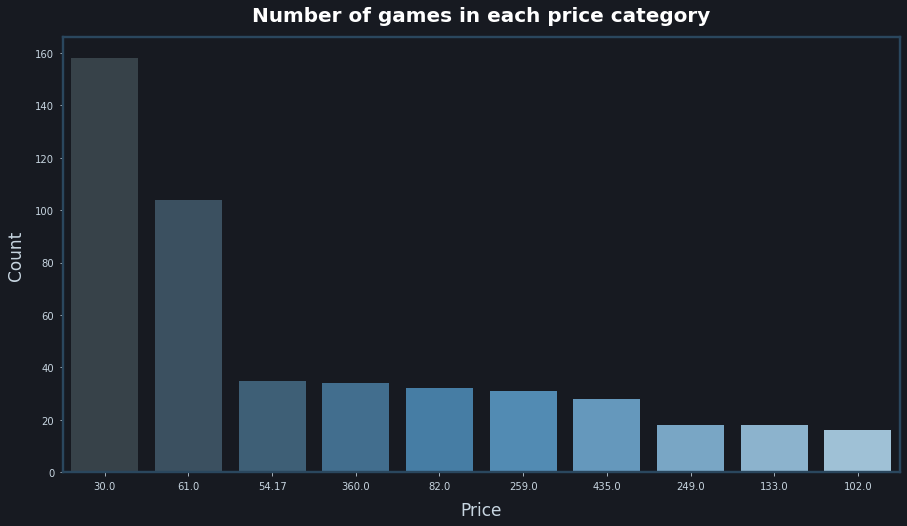

In [17]:
# Price/count plot
prices_counts = df_ftp[df_ftp.Price > 0].Price.value_counts()
prices_counts = prices_counts.sort_values(ascending=False).iloc[:10]

plt.figure(figsize=(15, 8))
sns.barplot(x=prices_counts.index, y=prices_counts, order=prices_counts.index, palette='Blues_d')
plt.xlabel('Price')
plt.ylabel('Count')

plt.title('Number of games in each price category')

plt.show()

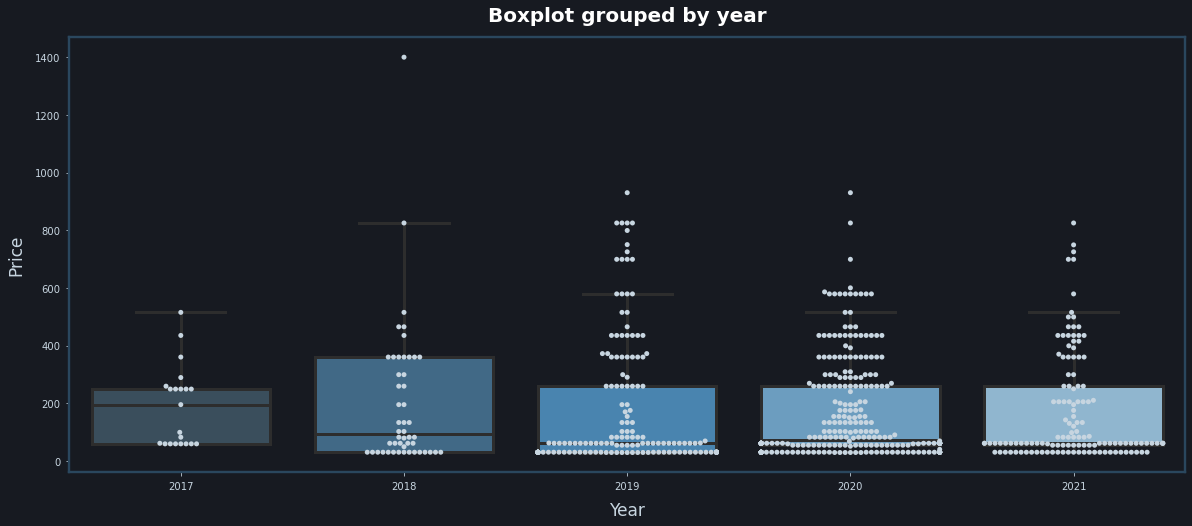

In [18]:
# Create boxplots for price of games by years
date_price = df[df_ftp.Price > 0].loc[:, ['Release date', 'Price']]
date_price['Release date'] = date_price['Release date'].dt.year
date_price = date_price[date_price['Release date'] > 2016]

# Sort to get a swarmplot without multiple outliers
date_price = date_price.sort_values('Price')

plt.figure(figsize=(20, 8))
sns.boxplot(x='Release date', y='Price', data=date_price, showfliers = False, linewidth=3, palette='Blues_d')
sns.swarmplot(x='Release date', y='Price', data=date_price[:-5], color="#c7d5e0")
plt.xlabel('Year')
plt.ylabel('Price')

plt.title('Boxplot grouped by year')

plt.show()

### Amount of games

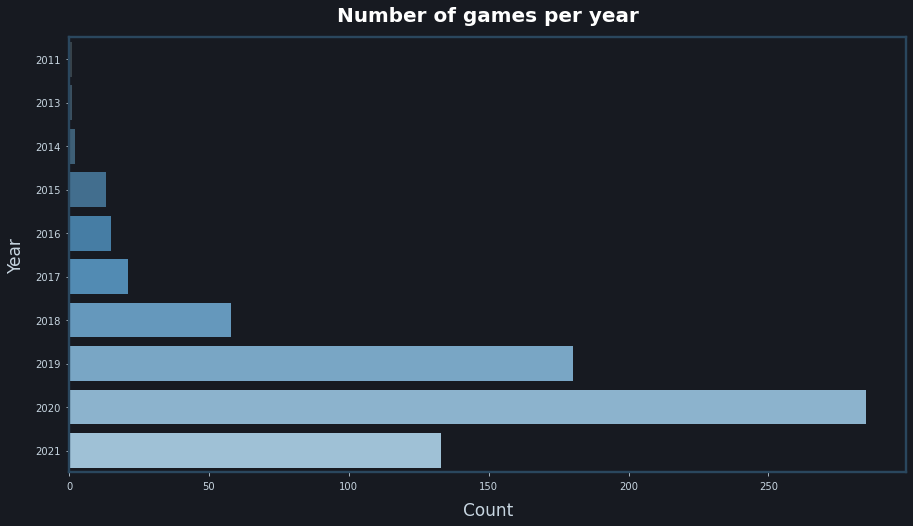

In [19]:
# Amount of games per year
games_per_year = df['Release date'].dt.year.value_counts()

plt.figure(figsize=(15, 8))
sns.barplot(games_per_year, games_per_year.index, orient='h', order=sorted(games_per_year.index), palette='Blues_d')
plt.xlabel('Count')
plt.ylabel('Year')

plt.title('Number of games per year')

plt.show()

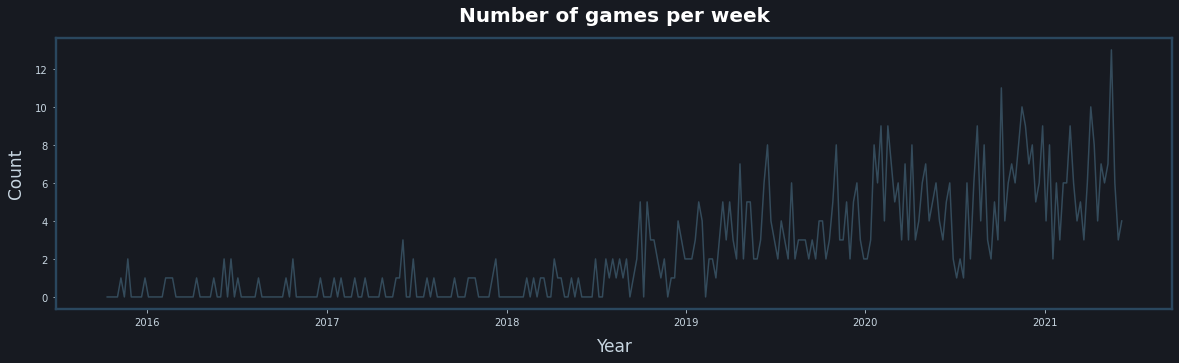

In [20]:
# Amount of games per year
games_per_week = pd.Series(1, index=df['Release date'])
games_per_week = games_per_week.resample('W').count()

plt.figure(figsize=(20, 5))
sns.lineplot(games_per_week.index[210:], games_per_week[210:])
plt.xlabel('Year')
plt.ylabel('Count')

plt.title('Number of games per week')

plt.show()

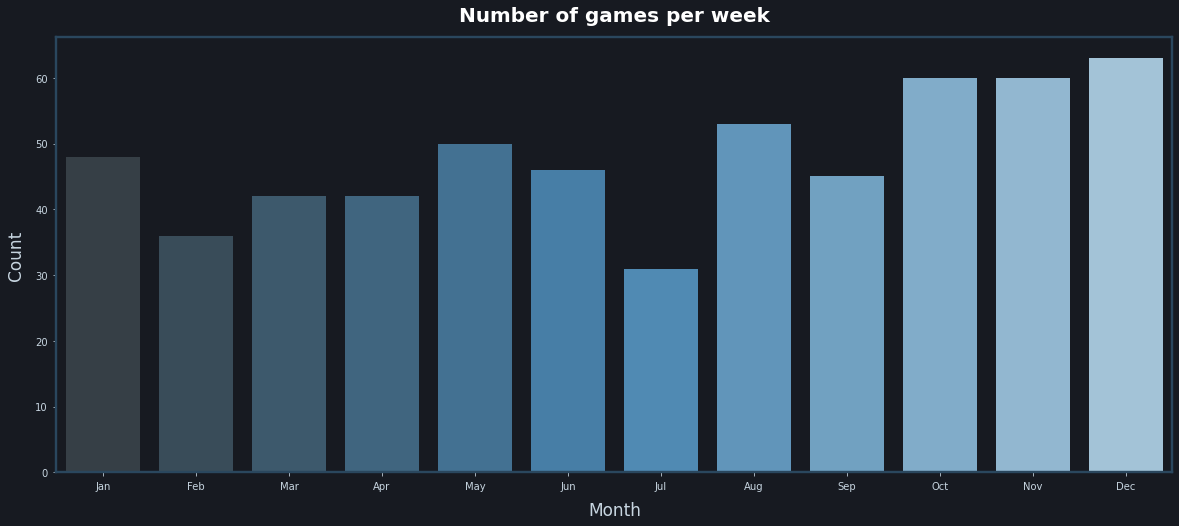

In [21]:
# Number of games per month (without 2021)
games_per_month = df[df['Release date'] < '2021-01-01']['Release date'].dt.month. \
                     value_counts().sort_index()

months = pd.date_range('2020-01-01', '2020-12-31', freq='MS').strftime('%b').tolist()

plt.figure(figsize=(20, 8))
sns.barplot(x=months, y=games_per_month, palette='Blues_d')
plt.ylabel('Count')
plt.xlabel('Month')

plt.title('Number of games per week')

plt.show()

### Reviews

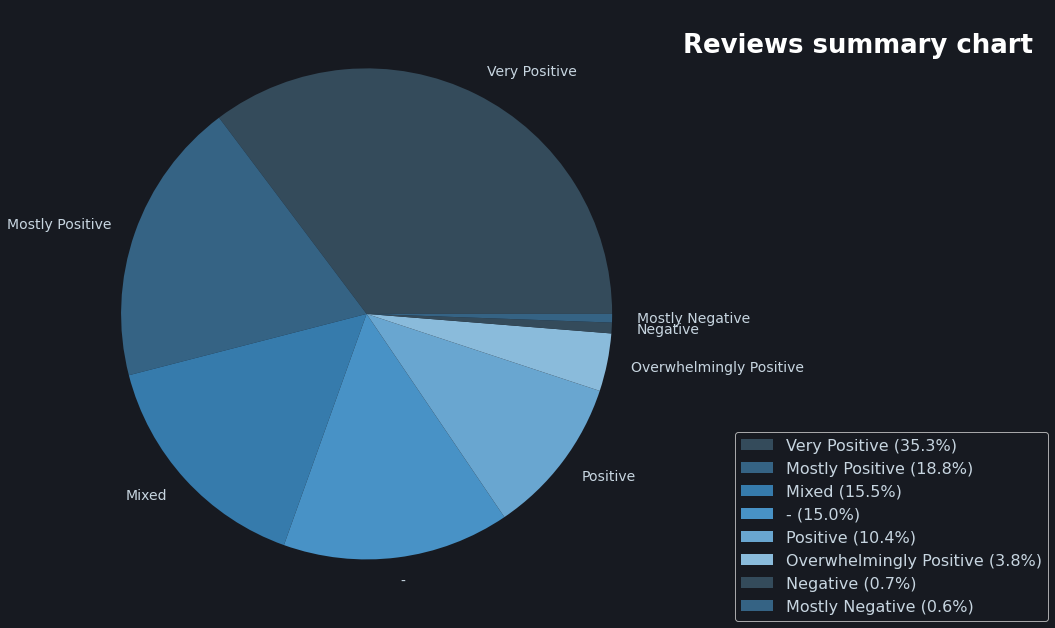

In [22]:
# Create a pie chart for reviews summary
rev_sum = df['Reviews summary'].value_counts()
rev_sum_perc = [round(x / np.sum(rev_sum) * 100, 1) for x in rev_sum]

plt.figure(figsize=(11, 15))
plt.rcParams['font.size'] = 14
plt.pie(rev_sum, labels=rev_sum.index, labeldistance=1.1)
plt.legend(['{0} ({1}%)'.format(x, y) for x, y in zip(rev_sum.index, rev_sum_perc)], fontsize=16, loc=(1.1,0))

plt.title('Reviews summary chart', x=1.3, y=0.9, fontsize=26)

plt.show()

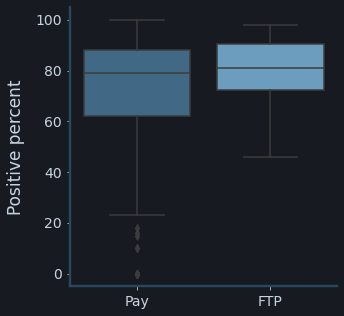

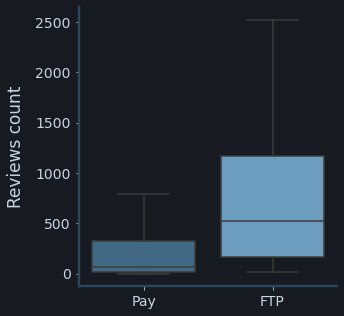

In [23]:
# Compare FTP and Paid games by users reviews
def create_catplot(x, y, data, fliers=True):
    sns.catplot(x=x, y=y, data=data, kind='box', showfliers=fliers, palette='Blues_d')
    plt.xlabel("")
    plt.show()


create_catplot('FTP', 'Positive percent', df_ftp)
create_catplot('FTP', 'Reviews count', df_ftp, False)

## Tags

In [24]:
# Get all unique values and count their number
tags_count = df.Tags.explode().value_counts()

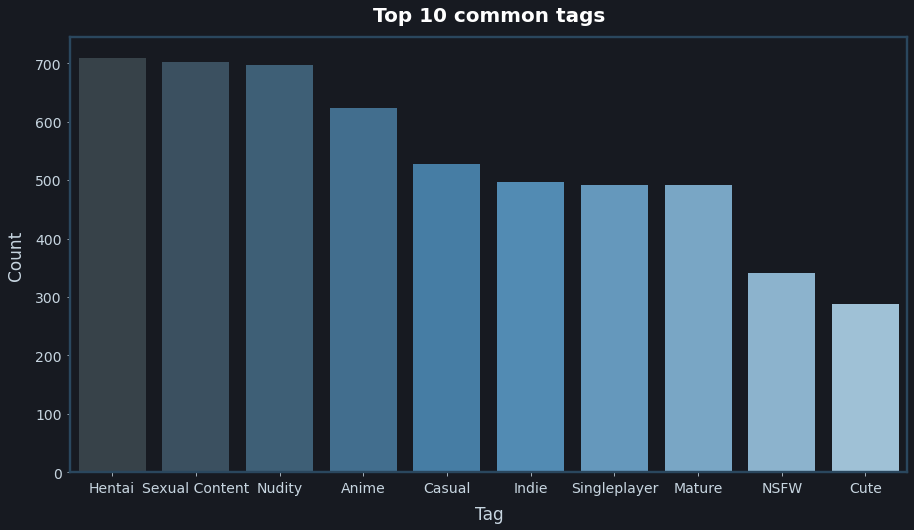

In [25]:
# Create barplot top 10 common tags
plt.figure(figsize=(15, 8))
sns.barplot(x=tags_count[:10].index, y=tags_count[:10], palette='Blues_d')
plt.xlabel('Tag')
plt.ylabel('Count')

plt.title('Top 10 common tags')

plt.show()

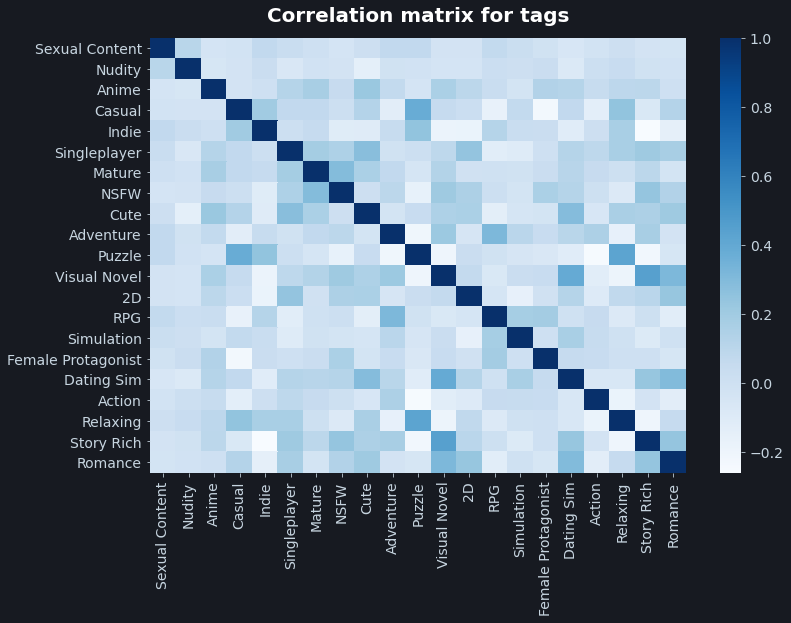

In [26]:
# Create correlation matrix for tags
def mark_tags(tags):
    return [1 if x in tags else 0 for x in tags_count.index[1:22]]
    

tags_for_cor = pd.DataFrame.from_records(df.Tags.apply(mark_tags), columns=tags_count.index[1:22])

plt.figure(figsize=(12, 8))
sns.heatmap(tags_for_cor.corr(), cmap='Blues')

plt.title('Correlation matrix for tags')

plt.show()

In [27]:
# Interesting results among tags
interesting_tags = ['VR', 'LGBTQ+', 'Story Rich', 
                    'Psychological Horror', 'Early Access', 
                    'Immersive Sim', 'Education', 'Software', 'Cats']

interesting_tags_dict = dict(zip(interesting_tags, [tags_count[x] for x in interesting_tags]))
interesting_tags_dict = {k: str(v) for k, v in sorted(interesting_tags_dict.items(), key=lambda item: item[1], reverse=True)}
interesting_tags_ser = pd.Series(interesting_tags_dict)

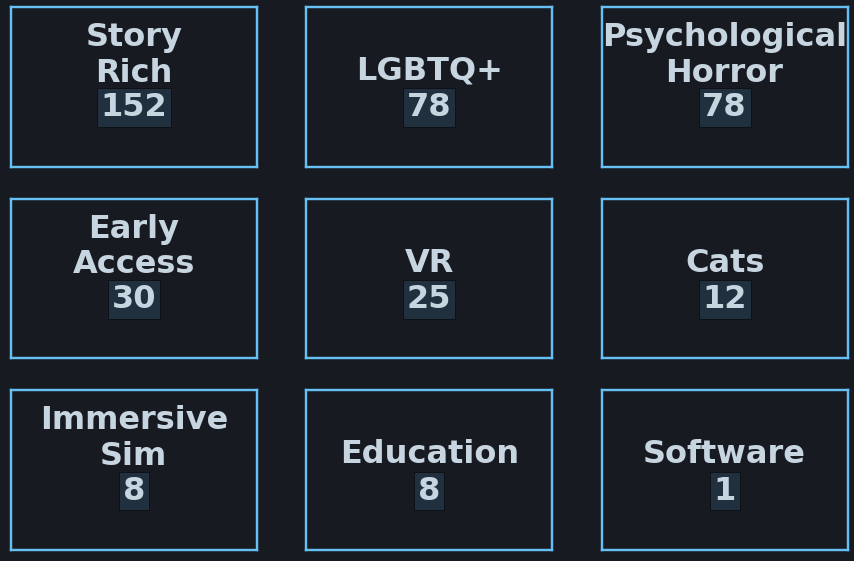

In [28]:
# Create plot for interesting results
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

index = 0
for i in range(3):
    for j in range(3):
        tag = interesting_tags_ser.index[index].replace(' ', '\n')
        count = interesting_tags_ser[index]
        axes[i, j].text(x=0.5, y=0.6 if len(tag) < 10 else 0.7, s=tag, horizontalalignment='center',
                        verticalalignment='center', size=32, fontweight="bold")
        axes[i, j].text(x=0.5, y=0.37, s=count, horizontalalignment='center', verticalalignment='center', size=32,
                           fontweight="bold", bbox=dict(facecolor='#2a475e', alpha=0.5))
        axes[i, j].spines['bottom'].set_color('#66c0f4')
        axes[i, j].spines['top'].set_color('#66c0f4') 
        axes[i, j].spines['right'].set_color('#66c0f4')
        axes[i, j].spines['left'].set_color('#66c0f4')
        axes[i, j].xaxis.set_major_locator(ticker.NullLocator())
        axes[i, j].yaxis.set_major_locator(ticker.NullLocator())
        index += 1

plt.show()

### Developers and publishers

In [29]:
# Compare different publishers and developers by number of games
popular_publishers = df.Publisher.value_counts()
popular_developers = df.Developer.value_counts()

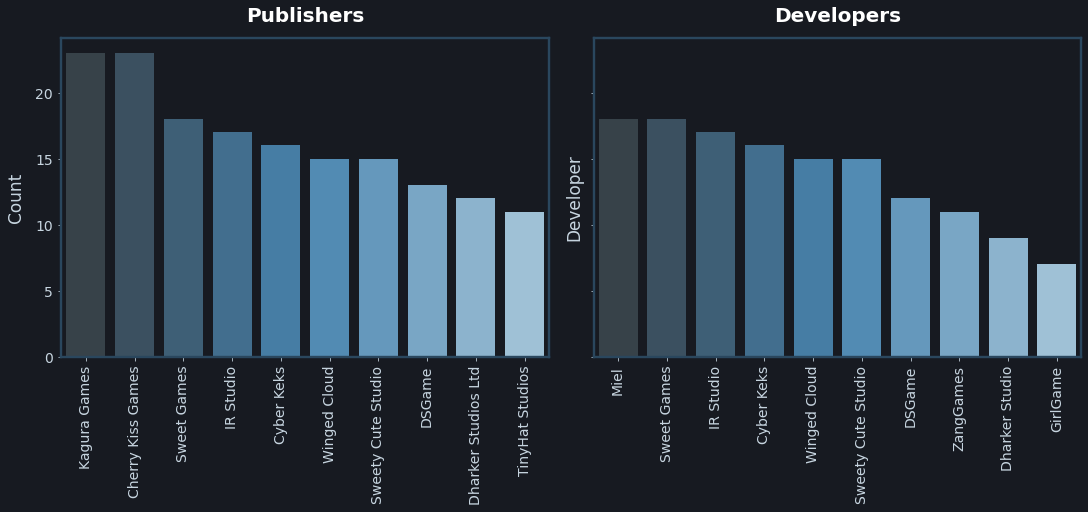

In [30]:
def create_plot_for_devs_and_publs(data, ax, title):
    sns.barplot(data.index[:10], data[:10], ax=axes[ax], palette='Blues_d')
    axes[ax].tick_params('x', labelrotation=90)
    axes[ax].set_title(title)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharey=True, constrained_layout=True)

create_plot_for_devs_and_publs(popular_developers, 1, 'Developers')
create_plot_for_devs_and_publs(popular_publishers, 0, 'Publishers')
axes[0].set_ylabel('Count')

plt.show()

#### Compare two biggest publishers

In [31]:
# Get two biggest publishers and compare them
best_publs = df[df.Publisher.isin(popular_publishers.index[0:2])]

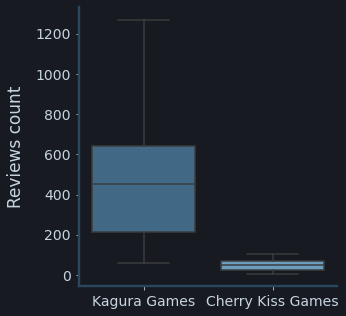

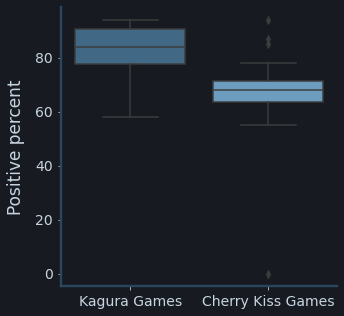

In [32]:
create_catplot('Publisher', 'Reviews count', best_publs, False)
create_catplot('Publisher', 'Positive percent', best_publs, True)

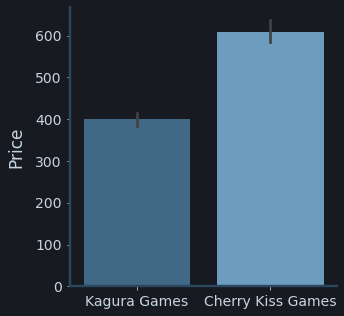

In [33]:
# To compare the price I will create barplot with errorbar
sns.catplot(x="Publisher", y="Price", data=best_publs, kind="bar", palette='Blues_d')
plt.xlabel('')

plt.show()

### Word cloud for game titles

In [34]:
# Get all words from game titles
title_words = []

def edit_and_save_words(val):
    val_clear = re.sub(r'\W', ' ', val).split()
    [title_words.append(word.strip().lower()) \
     for word in val_clear if len(word) > 1]


df.Title.apply(edit_and_save_words)

0      None
1      None
2      None
3      None
4      None
       ... 
704    None
705    None
706    None
707    None
708    None
Name: Title, Length: 709, dtype: object

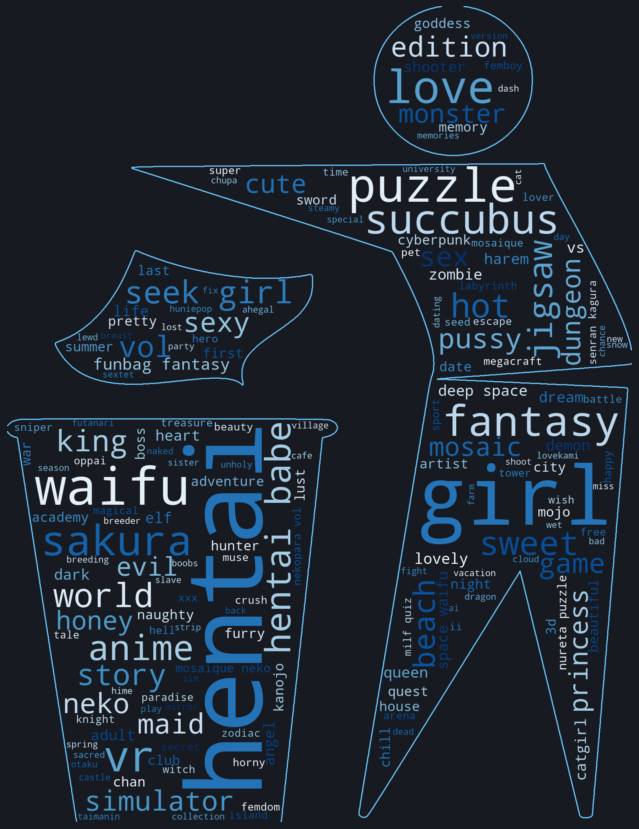

In [35]:
# Create WordCloud
def wordcloud(char, img_path, color):
    plt.subplots(figsize=(15,15))
    mask = np.array(Image.open(img_path))
    wc = WordCloud(stopwords=set(STOPWORDS),
                   mask=mask, background_color="#171a21",
                   contour_width=3, contour_color=color,
                   max_words=180, max_font_size=256,
                   random_state=42, width=mask.shape[1],
                   colormap="Blues",
                   height=mask.shape[0])
    wc.generate(' '.join(char))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()


wordcloud(title_words, "pic_for_wc.png", "#66c0f4")